![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/healthcare-nlp/02.1.Scope_window_tuning_assertion_status_detection.ipynb)

# Clinical Assertion Status: Tuning the Scope Window.

In the previous [2. Clinical Assertion Model Notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Healthcare/2.Clinical_Assertion_Model.ipynb), we learnt the following aspects of Spark NLP Assertion Status Identification:
- It's trained using a deep neural network architecture based on a Bi-LSTM framework, and is a modified version of the architecture proposed by Federico Fancellu, Adam Lopez and Bonnie Webber ([Neural Networks For Negation Scope Detection](https://aclanthology.org/P16-1047.pdf)).
- In the proposed implementation, input units depend on the
target tokens (a named entity) and the neighboring words that
are explicitly encoded as a sequence using word embeddings.
- It's been empirically observed that that 95% of the scope tokens (neighboring words) fall in a window of 9 tokens to the left and 15
to the right of the target tokens in the same dataset. We call that the "Scope Window", and is represented by setting the tokens before and after in brackets [9,15].

From version 3.4.2, we allow the possibility of setting your own **Scope Window** with the `.setScopeWindow()` in `AssertionDLApproach()` as shows the following example:

```
assertion_status = AssertionDLApproach() \
          .setGraphFolder("assertion_dl/") \
          .setInputCols("sentence", "chunk", "embeddings") \
          .setOutputCol("assertion") \
          .setStartCol("start") \
          .setEndCol("end") \
          .setLabelCol("label") \
          .setLearningRate(0.01) \
          .setDropout(0.15) \
          .setBatchSize(16) \
          .setEpochs(3) \
          .setScopeWindow([9, 15])\     # NEW! Scope Window!
          .setValidationSplit(0.2) \
          .setIncludeConfidence(True)
```

**Colab Setup**

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
! pip install -q johnsnowlabs==5.1.0

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import nlp, medical

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install()

In [ ]:
from johnsnowlabs import nlp, medical, visual
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start()

In [ ]:
spark

In [ ]:
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pyspark.sql as SQL
from pyspark import keyword_only

# Assertion Status Dataframe
We are going to use the example dataframe for testing Assertion Status, available [here](https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/ner/i2b2_assertion_sample.csv)

In [ ]:
!wget -q https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/ner/i2b2_assertion_sample.csv

### Checking `present`, `absent` and `hypothetical` statuses

In [ ]:
assertion_df = spark.read.option("header", True).option("inferSchema", "True").csv("i2b2_assertion_sample.csv")
assertion_df = assertion_df.filter(assertion_df.label.isin(['present', 'absent', 'hypothetical']))

In [ ]:
assertion_df.show(50)

+--------------------+--------------------+------------+-----+---+
|                text|              target|       label|start|end|
+--------------------+--------------------+------------+-----+---+
|Due to dye load r...|the coronary disease|     present|    7|  9|
|She has no histor...|       liver disease|      absent|    5|  6|
|1. Undesired fert...| undesired fertility|     present|    1|  2|
|3) STATUS POST FA...|                fall|     present|    3|  3|
|On physical exam ...|        exophthalmos|      absent|   15| 15|
|Abdomen distended...|nohepatosplenomegaly|      absent|   13| 13|
|PMH : Carpal tunn...|        hypertension|     present|    6|  6|
|In the past , he ...|      cns metastases|      absent|   14| 15|
|75 y / o F with h...|typical flare sym...|     present|   18| 20|
|There is no pneum...|        pneumothorax|      absent|    3|  3|
|IF SIGNS AND SYMP...|              chills|hypothetical|   11| 11|
|History of gastro...|                rash|     present|   14|

In [ ]:
assertion_df.select('text').show()

+--------------------+
|                text|
+--------------------+
|Due to dye load r...|
|She has no histor...|
|1. Undesired fert...|
|3) STATUS POST FA...|
|On physical exam ...|
|Abdomen distended...|
|PMH : Carpal tunn...|
|In the past , he ...|
|75 y / o F with h...|
|There is no pneum...|
|IF SIGNS AND SYMP...|
|History of gastro...|
|In addition , he ...|
|Carotid pulsation...|
|12. PE 2018-11-17...|
|His abdomen is so...|
|MRI lumbar spine ...|
|NSR R 60 Normal a...|
|There was trace m...|
|Return to the ER ...|
+--------------------+
only showing top 20 rows



In [ ]:
assertion_df.groupBy('label').count().orderBy('count', ascending=False).show(truncate=False)

+------------+-----+
|label       |count|
+------------+-----+
|present     |664  |
|absent      |228  |
|hypothetical|50   |
+------------+-----+



# Spliting into Training and Test sets
We are going to train with different Scope Windows and see the difference in performance. To do that, we are going to create a Training and Test dataset, and use the Training dataset to train different models with different Scope Windows.


In [ ]:
(training_data, test_data) = assertion_df.randomSplit([0.8, 0.2], seed = 100)
print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 767
Test Dataset Count: 175


Let's check the distribution of both dataframes to make sure we get enough examples for training and also for testing to make the experiment reliable

In [ ]:
training_data.groupBy('label').count().orderBy('count', ascending=False).show(truncate=False)

+------------+-----+
|label       |count|
+------------+-----+
|present     |547  |
|absent      |185  |
|hypothetical|35   |
+------------+-----+



In [ ]:
test_data.groupBy('label').count().orderBy('count', ascending=False).show(truncate=False)

+------------+-----+
|label       |count|
+------------+-----+
|present     |117  |
|absent      |43   |
|hypothetical|15   |
+------------+-----+



# Preparing the Test Set for Evaluation during Training
To use `setTestDataset` in AssertionDLApproach(), we need the transformed parquet results with the embeddings, not the original dataframe. Let's calculate them.

In [ ]:
document = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

chunk = nlp.Doc2Chunk()\
    .setInputCols("document")\
    .setOutputCol("chunk")\
    .setChunkCol("target")\
    .setStartCol("start")\
    .setStartColByTokenIndex(True)\
    .setFailOnMissing(False)\
    .setLowerCase(True)

token = nlp.Tokenizer()\
    .setInputCols(['document'])\
    .setOutputCol('token')

embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["document", "token"])\
    .setOutputCol("embeddings")

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


In [ ]:
clinical_assertion_pipeline = nlp.Pipeline(
    stages = [
    document,
    chunk,
    token,
    embeddings])

assertion_test_data = clinical_assertion_pipeline.fit(test_data).transform(test_data)

In [ ]:
assertion_test_data.write.mode('overwrite').parquet('i2b2_assertion_sample_test_data.parquet')

# Let's take a look at two trained Assertion models
Let's suppose we have two models, one with a Window Scope of [10,10] and another with no Window Scope [0,0].

What is the difference in the obtained results?

In [ ]:
!wget https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/healthcare-nlp/models/AssertionScopeWindow/window0.zip?raw=true -O window0.zip
!wget https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/healthcare-nlp/models/AssertionScopeWindow/window10.zip?raw=true -O window10.zip

In [ ]:
!unzip -o window0.zip
!unzip -o window10.zip

In [ ]:
# A model trained with setScopeWindow([0,0])
window_scope_0 = medical.AssertionDLModel.load('./window0')\
  .setInputCols(["document", "chunk", "embeddings"]) \
  .setOutputCol("assertion_scope_0")

# A model trained with setScopeWindow([10,10])
window_scope_10 = medical.AssertionDLModel.load('./window10')\
  .setInputCols(["document", "chunk", "embeddings"]) \
  .setOutputCol("assertion_scope_10")

In [ ]:
clinical_assertion_pipeline = nlp.Pipeline(
    stages = [
    document,
    chunk,
    token,
    embeddings,
    window_scope_0,
    window_scope_10])

In [ ]:
res = clinical_assertion_pipeline.fit(test_data).transform(test_data)

In [ ]:
# from pyspark.sql import functions as F

res_exploded = res.select(F.explode(F.arrays_zip(res.document.result,
                                                 res.chunk.result,
                                                 res.assertion_scope_0.result,
                                                 res.assertion_scope_10.result)).alias('fields'))\
                  .select(F.expr("fields['0']").alias("text"),
                          F.expr("fields['1']").alias("chunk"),
                          F.expr("fields['2']").alias("scope_0"),
                          F.expr("fields['3']").alias("scope_10") )

## Let's take a look at the difference between them
We will select the difference results of Assertion Model, comparing Scope Window is [0,0] (no context) to Scope Window [10,10].

More specifically, let's see how the Assertion Model learns that sentences are `absent` just by having some context (10 words both sides).

In [ ]:
res_exploded.filter(F.expr('scope_0=="present" AND scope_10=="absent"')).show()

+--------------------+--------------------+-------+--------+
|                text|               chunk|scope_0|scope_10|
+--------------------+--------------------+-------+--------+
|54 yo F with Croh...|                 sob|present|  absent|
|A cardiology cons...|anterolateral cha...|present|  absent|
|A small intimal t...|            sequelae|present|  absent|
|Abdominal examina...|        organomegaly|present|  absent|
|According to her ...|             her ptx|present|  absent|
|CONCLUSION : Impr...|the right upper l...|present|  absent|
|EKG demonstrated ...|    ischemic changes|present|  absent|
|HEIGHT 63 HEENT N...|              masses|present|  absent|
|HEIGHT 63 HEENT N...|              murmur|present|  absent|
|His stools were n...|guaiac positive s...|present|  absent|
|IF SIGNS AND SYMP...|              chills|present|  absent|
|MOUTH NORMAL NECK...|         ext lesions|present|  absent|
|No aortic regurgi...|aortic regurgitation|present|  absent|
|No calf tenderness .|  

By increasing the scope window, we are able to pick words expressing negation, as `no` and `denies`



| text 	| chunk 	| assertion [0,0] 	| assertion [10,10] 	|
|---	|---	|---	|---	|
| **NO** _aortic regurgitation_ present 	| aortic regurgitation 	| present 	| absent 	|
| **NO** _calf tenderness_ 	| calf tenderness 	| present 	| absent 	|
| She **DENIES** any CP ... _abd pain_ 	| abd pain 	| present 	| absent 	|
| She **DENIES** any _vomiting_... 	| vomimting 	| present 	| absent 	|
| ...**NO** _guarding_ and no hepatosplenomegaly 	| guarding 	| present 	| absent 	|

... and thanks to having a scope of [10,10] we are able to pick the word `DENIES` in the third row:

```She denies any CP / cough / fever / abd pain / diarrhea / black or bloody stools / headache ```

If you train with a scope less than 5 (the distance in tokens between the word `DENIES` and `ABD PAIN`), you will get a `present` label, as shown in the table for Scope Window [0,0]


# How these two models were trained?
Let's take a look at how we Trained those models with specific values of `setScopeWindow()`

# Graph creation
Let's create a TF graph to train the neural network for Assertion Status purposes

In [ ]:
!pip install -q tensorflow==2.12.0
!pip install -q tensorflow-addons

#### We will use TFGraphBuilder annotator which can be used to create graphs in the model training pipeline.

#### TFGraphBuilder inspects the data and creates the proper graph if a suitable version of TensorFlow (<= 2.7 ) is available. The graph is stored in the defined folder and loaded by the approach.

In [ ]:
graph_folder= "./tf_graphs"

assertion_graph_builder = medical.TFGraphBuilder()\
    .setModelName("assertion_dl")\
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setLabelColumn("label")\
    .setGraphFolder(graph_folder)\
    .setGraphFile("assertion_graph.pb")\
    .setMaxSequenceLength(250)\
    .setHiddenUnitsNumber(25)

In [ ]:
'''
# ready to use tf_graph

!mkdir training_logs
!mkdir tf_graphs

!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/nerdl_graph/blstm_34_32_30_200_3.pb -P /content/tf_graphs
'''

In [ ]:
'''
# Create custom graph

medical.tf_graph.print_model_params("assertion_dl")

feat_size = 200
n_classes = 3

medical.tf_graph.build("assertion_dl",
                        build_params={"n_classes": n_classes},
                        model_location= "./tf_graphs",
                        model_filename="blstm_34_32_30_{}_{}.pb".format(feat_size, n_classes))
'''

# Baseline: No scope window [-1,1] and `absence` tag
Let's check the baseline to "absence of scope window". By doing `.setScopeWindow([-1,-1])` or not setting it at all, we will tell the AssertionStatus model to look at all the words in the sentence or document, up to a max number of tokens set in the `setMaxSentLen()` function.

If we had a sentence consisting on 5 tokens, being `pneumothorax` the extracted NER chunk, a window of [-1,-1] would take all the sentence as context.

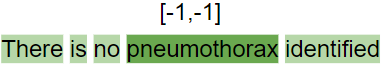

In [ ]:
assertionStatus = medical.AssertionDLApproach()\
    .setLabelCol("label")\
    .setInputCols("document", "chunk", "embeddings")\
    .setOutputCol("assertion")\
    .setBatchSize(128)\
    .setLearningRate(0.01)\
    .setDropout(0.1)\
    .setEpochs(25)\
    .setMaxSentLen(250)\
    .setStartCol("start")\
    .setEndCol("end")\
    .setEnableOutputLogs(True)\
    .setIncludeConfidence(True)\
    .setOutputLogsPath('training_logs/')\
    .setGraphFolder(graph_folder) \
    .setGraphFile(f"{graph_folder}/assertion_graph.pb")\
    .setTestDataset(path="i2b2_assertion_sample_test_data.parquet", read_as='SPARK', options={'format': 'parquet'})

clinical_assertion_pipeline = nlp.Pipeline(
    stages = [
    document,
    chunk,
    token,
    embeddings,
    assertion_graph_builder,
    assertionStatus])



In [ ]:
%%time
assertion_model = clinical_assertion_pipeline.fit(training_data)

TF Graph Builder configuration:
Model name: assertion_dl
Graph folder: ./tf_graphs
Graph file name: assertion_graph.pb
Build params: {'n_classes': 3, 'feat_size': 200, 'max_seq_len': 250, 'n_hidden': 25}


Instructions for updating:
non-resource variables are not supported in the long term


Device mapping: no known devices.


Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Device mapping: no known devices.
assertion_dl graph exported to ./tf_graphs/assertion_graph.pb
CPU times: user 10.2 s, sys: 490 ms, total: 10.7 s
Wall time: 2min 24s


```
Quality on test dataset:
time to finish evaluation: 0.51s
Total test loss: 1.1513	Avg test loss: 0.5756
label	           tp	 fp	fn	 prec	      rec	       f1
present			108	 18	 9	 0.85714287	0.9230769	 0.8888889
hypothetical		6	   6	 9	 0.5	       0.4	       0.44444448
absent			 29	   8	 14	0.7837838	 0.6744186	 0.725
tp: 143 fp: 32 fn: 32 labels: 3
Macro-average	 prec: 0.7136423, rec: 0.66583186, f1: 0.6889086
Micro-average	 prec: 0.81714284, rec: 0.81714284, f1: 0.81714284
CPU times: user 157 ms, sys: 43.6 ms, total: 201 ms
Wall time: 3min 8s
```

The results have a good accuracy for `present` label, but not a good one on `hypothetical` or `absent`.

The cause for the low accuracy for `hypothetical` may be the low number of examples.

But the question here is ... can we do better with the amount of examples we are given?

The answer is yes, and we can accomplish that by **finetuning the Scope Window**.



In [ ]:
assertion_model.stages[-1].write().overwrite().save('models/window_-1_-1/')

# Scope Window: how different values affect the results

Although having all the words by default may be a good starting baseline, it's clearly not the best. Let's see some examples.

## Good, but not optimal?
These windows would be more optimal for absence for some examples including `no` as a word before the NER chunk

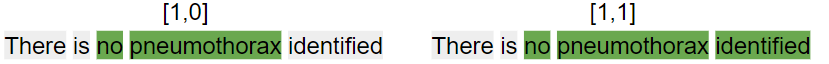

## Out of reach?

However, setting small windows would prevent us from capturing negation in longer contexts:

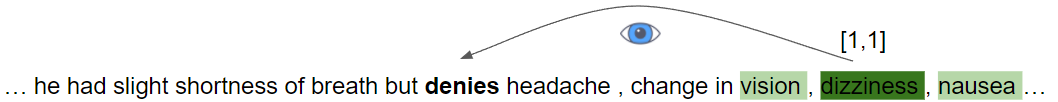

## Too much awareness?

That's why big contexts are usually a good idea. But, how big? If they are too big, we can incur in false positives (FP) as illustrates the following example:

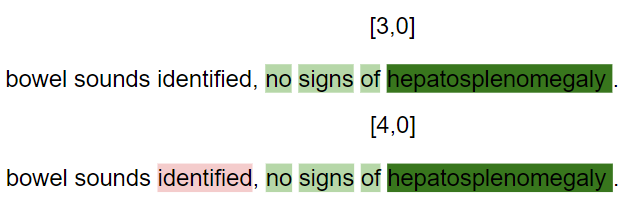

## Grid-search and Finetuning of the Scope Window values
* As commented before, the default Scope Window is [-1,-1] what means "all the context available in the sentence / document, up to a max number of tokens set in the `setMaxSentLen()` function.
* Empirically, and in general terms, the optimal window is around [9, 15]
* However, it's very important you finetune the Scope Window to your **dataset**

Let's see how you can finetune to get the best of your AssertionStatusDLModel.

## Get a series of windows you want to test.
In this example, we will test from `[0,0]` to `[50,50]` and then `[-1,-1]`

In [ ]:
scope_window = [0,0]

In [ ]:
assertionStatus = medical.AssertionDLApproach()\
    .setLabelCol("label")\
    .setInputCols("document", "chunk", "embeddings")\
    .setOutputCol("assertion")\
    .setBatchSize(128)\
    .setLearningRate(0.01)\
    .setEpochs(25)\
    .setStartCol("start")\
    .setEndCol("end")\
    .setEnableOutputLogs(True)\
    .setIncludeConfidence(True)\
    .setOutputLogsPath('training_logs/')\
    .setGraphFolder(graph_folder)\
    .setGraphFile(f"{graph_folder}/assertion_graph.pb")\
    .setTestDataset(path="i2b2_assertion_sample_test_data.parquet", read_as='SPARK', options={'format': 'parquet'})\
    .setScopeWindow(scope_window)


clinical_assertion_pipeline = nlp.Pipeline(
    stages = [
    document,
    chunk,
    token,
    embeddings,
    assertion_graph_builder,
    assertionStatus])

In [ ]:
%%time
assertion_model = clinical_assertion_pipeline.fit(training_data)

TF Graph Builder configuration:
Model name: assertion_dl
Graph folder: ./tf_graphs
Graph file name: assertion_graph.pb
Build params: {'n_classes': 3, 'feat_size': 200, 'max_seq_len': 250, 'n_hidden': 25}
Device mapping: no known devices.
Device mapping: no known devices.
assertion_dl graph exported to ./tf_graphs/assertion_graph.pb
CPU times: user 6.81 s, sys: 186 ms, total: 7 s
Wall time: 2min 21s


In [ ]:
assertion_model.stages[-1].write().overwrite().save('models/window_0_0/')

If you repeat the process with different scope_windows, and get the metrics, you will get a grid search table similar to the following one (using Scope Windows from 0 to 50, and also [-1, -1])

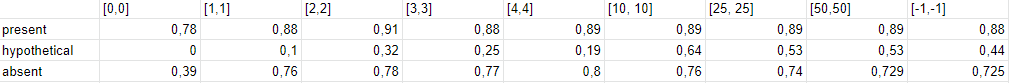

# Visualizing the metrics of different Scope Windows and making a decision

Let's plot the values in a chart to analyze the behaviour of the Scope Window

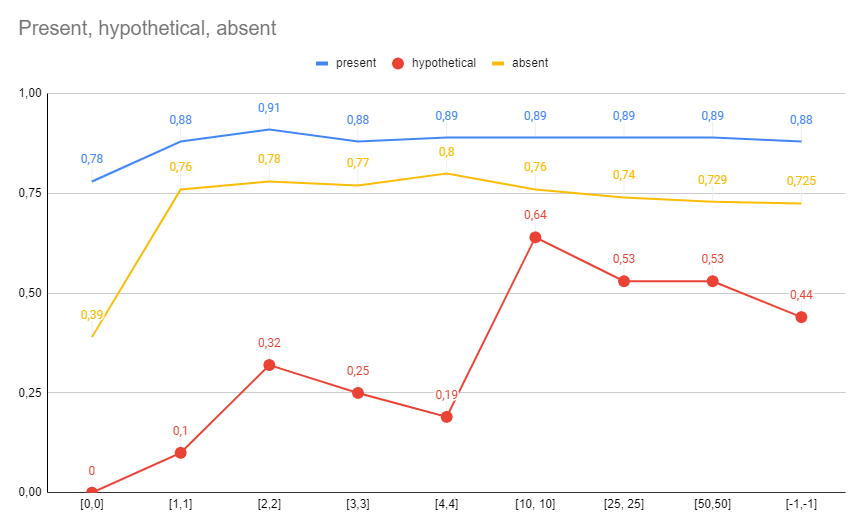

# Conclusions

## 1. Changing the window affects the accuracy of the model.
Going from a [0,0] no context to progressively increasing context to [10,10] makes the assertion model improve.

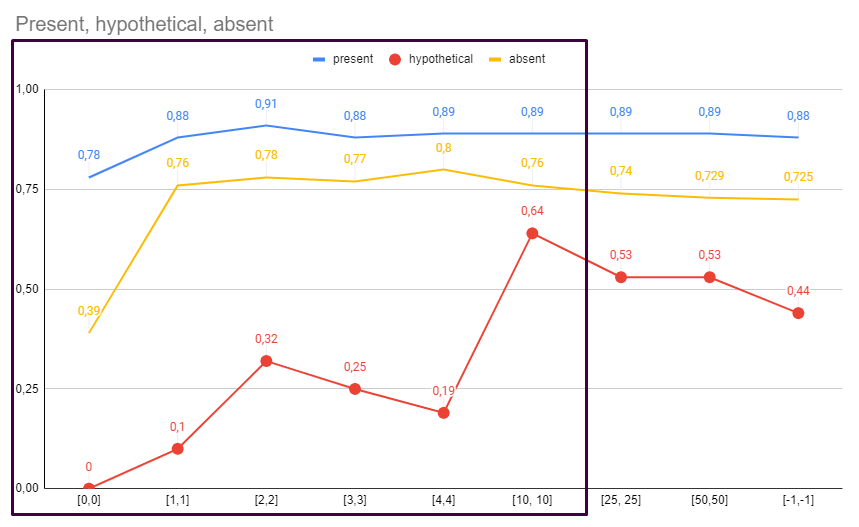

## 2. Keep in mind not all tags behave the same way
Let's take a look at the different in performance of the different Scope Windows for Presnet, Hypothetical and Absent.

* For `present`: The difference is not so huge as with the rest. This is evident: ner chunks are present just by appearing in the text. Of course there are modifiers around, that's why we go from 0.78 to 0.91 in some cases. But present is probably not the best assertion status to illustrate the power of the Scope Window.
* For `absent`: We get a big improvement when just adding a **1 word Scope Window**
* `hypothetical` is also very sensitive to the Scope window, as we can see in the chart.

## 3. `absent` duplicates its performance with 1 contex word
The chart shows how we can achieve a 2X the accuracy when we add 1 word to the context [1,1] compared to not having context [0,0].

Why is that happenning? If we take a look at the text, we can find a quick answer to the question: one of the main word of `absence` is `no`, which usually appears just before the ner chunk.

But of course there are other negation words which may appear much before or after (as the `denies` example in the previous section).

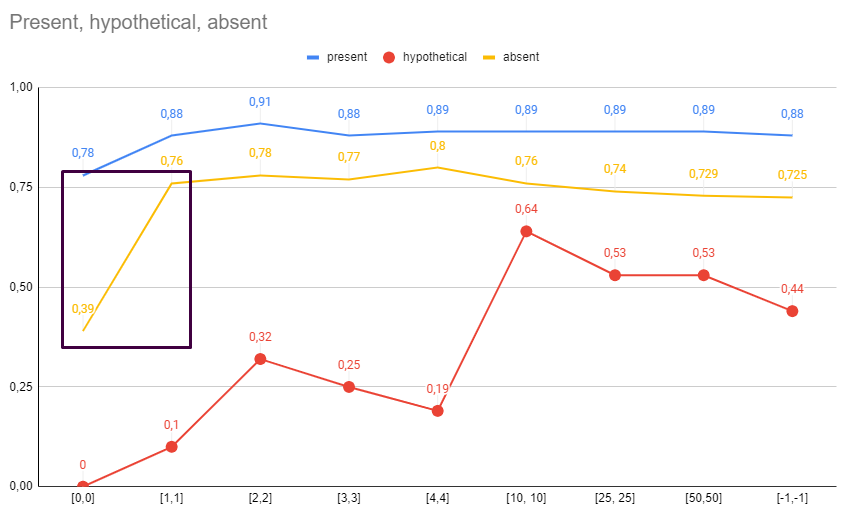

In [ ]:
windows = [0,1,2,3,4,10]

pd_df_absent = test_data.toPandas()
pd_df_absent = pd_df_absent[pd_df_absent['label']=='absent']

for r in pd_df_absent.itertuples():
    start = r.text.find(r.target)
    end = start + len(r.target)
    text_before = r.text[:start]
    text_end = r.text[end:]
    for w in windows:
        if w == 0:
            print(f"Window: {[w,w]}: {r.target}")
        else:
            print(f"Window: {[w,w]}: ..." + ' '.join(text_before.split(' ')[-1*(w+1):]) + ' ' + r.target + ' ' + ' '.join(text_end.split(' ')[:(w+1)]))
    print("="*50)

Window: [0, 0]: foot lesions
Window: [1, 1]: ...or  foot lesions  .
Window: [2, 2]: ...retinopathy or  foot lesions  .
Window: [3, 3]: ...no retinopathy or  foot lesions  .
Window: [4, 4]: ...with no retinopathy or  foot lesions  .
Window: [10, 10]: ...dependent diabetes mellitus x 15 years with no retinopathy or  foot lesions  .
Window: [0, 0]: sequelae
Window: [1, 1]: ...without  sequelae  .
Window: [2, 2]: ...was without  sequelae  .
Window: [3, 3]: ..., was without  sequelae  .
Window: [4, 4]: ...angiogram , was without  sequelae  .
Window: [10, 10]: ...arch of the aorta during the angiogram , was without  sequelae  .
Window: [0, 0]: nohepatosplenomegaly
Window: [1, 1]: ...,  nohepatosplenomegaly  .
Window: [2, 2]: ...present ,  nohepatosplenomegaly  .
Window: [3, 3]: ...sounds present ,  nohepatosplenomegaly  .
Window: [4, 4]: ...bowel sounds present ,  nohepatosplenomegaly  .
Window: [10, 10]: ...mild tenderness on the left , bowel sounds present ,  nohepatosplenomegaly  .
Window

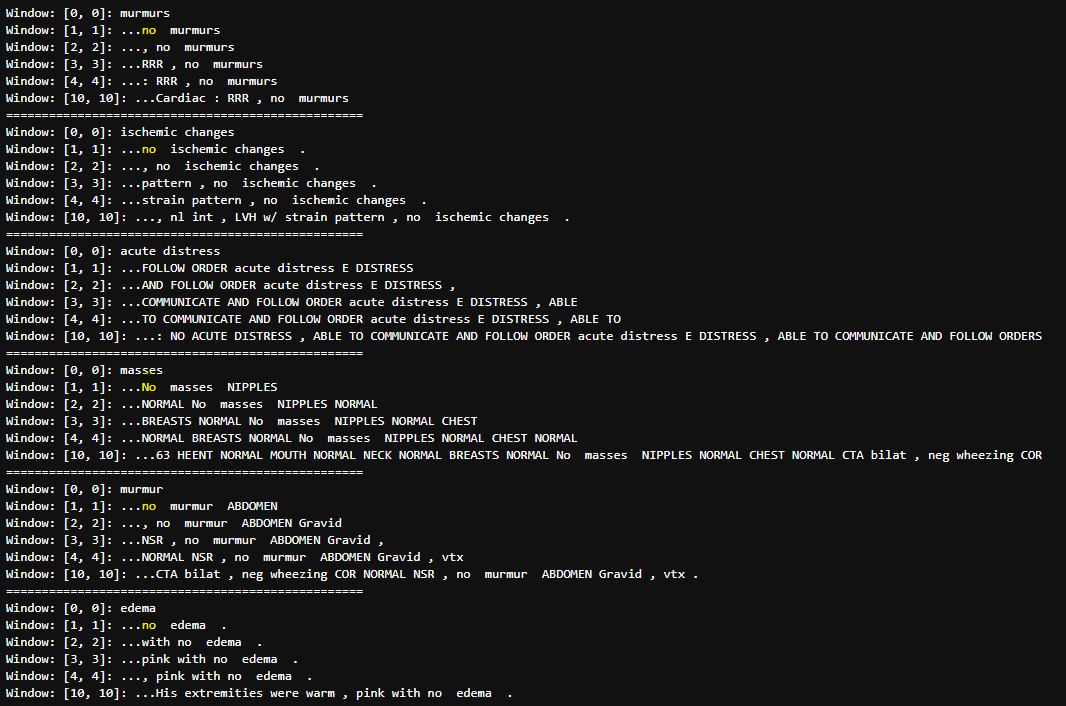

# 4: [-1,-1] or [9,15] are not always the best option

In our case, the best Scope Window is around [10,10] as shows the following chart:

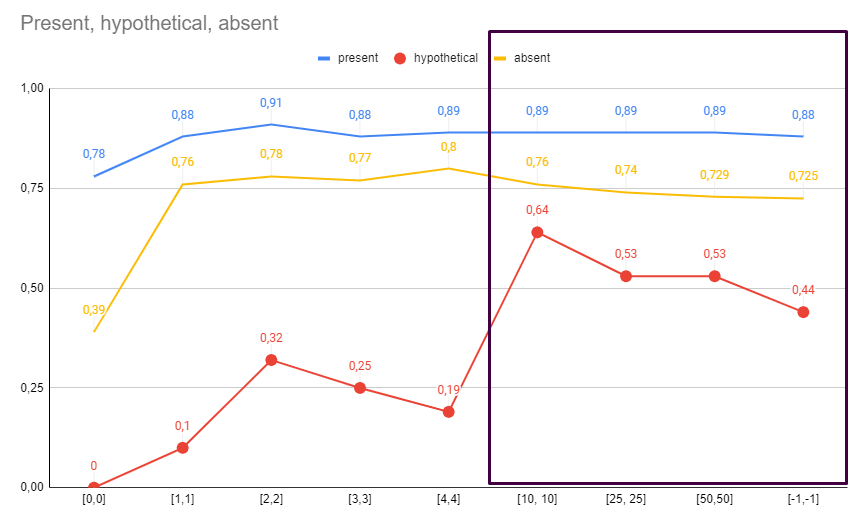

# Result

It seems we have found our sweet spot to maximize the performance of our model: `a Scope Window of [10,10]`.

We have not "Grid-searched" all the combinations, you can try to explore if you are able to improve the results of the [10,10] window.

In [ ]:
scope_window = [10,10]

assertionStatus = medical.AssertionDLApproach()\
    .setLabelCol("label")\
    .setInputCols("document", "chunk", "embeddings")\
    .setOutputCol("assertion")\
    .setBatchSize(128)\
    .setLearningRate(0.001)\
    .setEpochs(50)\
    .setStartCol("start")\
    .setEndCol("end")\
    .setEnableOutputLogs(True)\
    .setIncludeConfidence(True)\
    .setOutputLogsPath('training_logs/')\
    .setGraphFolder(graph_folder)\
    .setGraphFile(f"{graph_folder}/assertion_graph.pb")\
    .setTestDataset(path="i2b2_assertion_sample_test_data.parquet", read_as='SPARK', options={'format': 'parquet'})\
    .setScopeWindow(scope_window)


clinical_assertion_pipeline = nlp.Pipeline(
    stages = [
    document,
    chunk,
    token,
    embeddings,
    assertion_graph_builder,
    assertionStatus])



In [ ]:
%%time
assertion_model = clinical_assertion_pipeline.fit(training_data)

TF Graph Builder configuration:
Model name: assertion_dl
Graph folder: ./tf_graphs
Graph file name: assertion_graph.pb
Build params: {'n_classes': 3, 'feat_size': 200, 'max_seq_len': 250, 'n_hidden': 25}
Device mapping: no known devices.
Device mapping: no known devices.
assertion_dl graph exported to ./tf_graphs/assertion_graph.pb
CPU times: user 8.24 s, sys: 210 ms, total: 8.45 s
Wall time: 4min 19s


```
Quality on test dataset:
time to finish evaluation: 0.51s
Total test loss: 1.0135	Avg test loss: 0.5067
label			tp	 fp	 fn	 prec		rec			f1
present		  105	13	12	0.8898305	 0.8974359	 0.89361703
hypothetical	 10	 6	 5	 0.625		 0.6666667	 0.6451613
absent			32	9	 11	0.7804878	 0.74418604	0.7619048
tp: 147 fp: 28 fn: 28 labels: 3
Macro-average	 prec: 0.76510614, rec: 0.7694295, f1: 0.76726174
Micro-average	 prec: 0.84, rec: 0.84, f1: 0.84
CPU times: user 197 ms, sys: 35.9 ms, total: 233 ms
Wall time: 3min 13s
```